In [45]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Updated Imports
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize # Fixed location
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

import optuna

In [46]:
# Load Dataset
path = r"D:\binary-classification-mlops\data\raw\cereal.csv"
df = pd.read_csv(path)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (77, 16)


,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [47]:
# Clean cereal names
def clean_cereal_name(name: str) -> str:
    if not isinstance(name, str): return name
    name = name.lower().strip().replace("-", " ")
    name = re.sub(r"[^a-z0-9\s]", "", name)
    return re.sub(r"\s+", " ", name)

df["name"] = df["name"].apply(clean_cereal_name)

In [48]:
# Handle Negative Outliers in Numerical Columns
num_cols = ["calories","protein","fat","sodium","fiber","carbo","sugars","potass","vitamins","weight","cups"]
df[num_cols] = df[num_cols].mask(df[num_cols] < 0, pd.NA)
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.median()))

print("Missing values after cleaning:", df.isnull().sum().sum())

Missing values after cleaning: 0


In [49]:
# Define Target Variable (Feature Engineering)
def health_class(row):
    if row["fiber"] >= 7 and row["sugars"] <= 5 and row["calories"] <= 110:
        return 2   # Healthy
    elif row["fiber"] >= 3 and row["sugars"] <= 10:
        return 1   # Moderately healthy
    else:
        return 0   # Unhealthy

df["target"] = df.apply(health_class, axis=1)

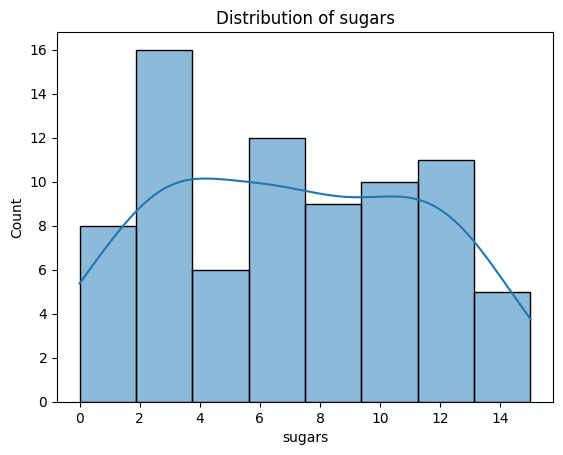

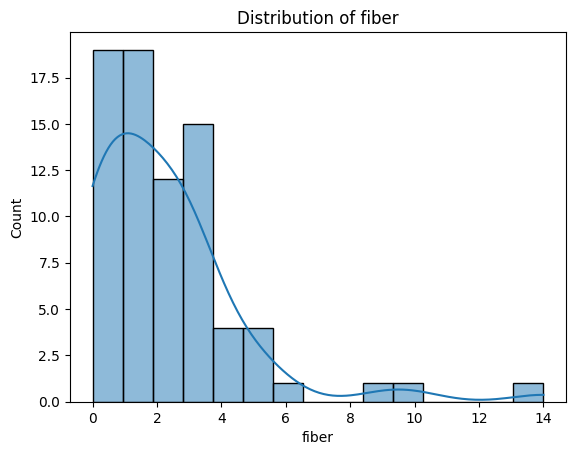

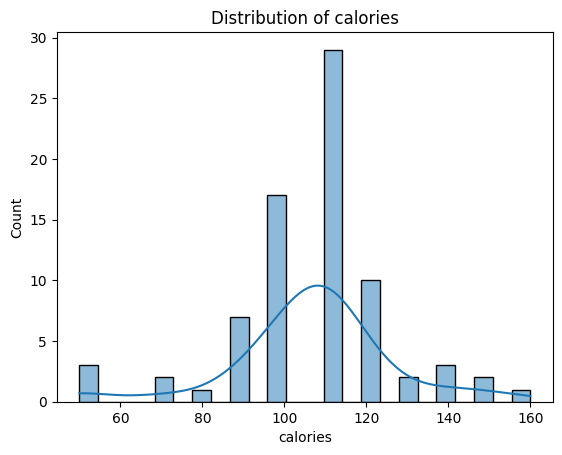

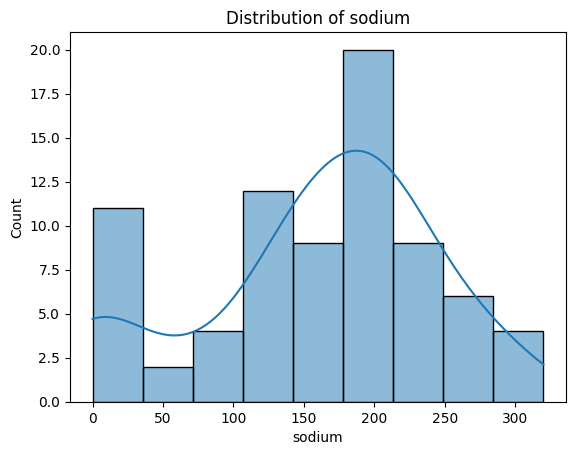

In [50]:
for col in ["sugars", "fiber", "calories", "sodium"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

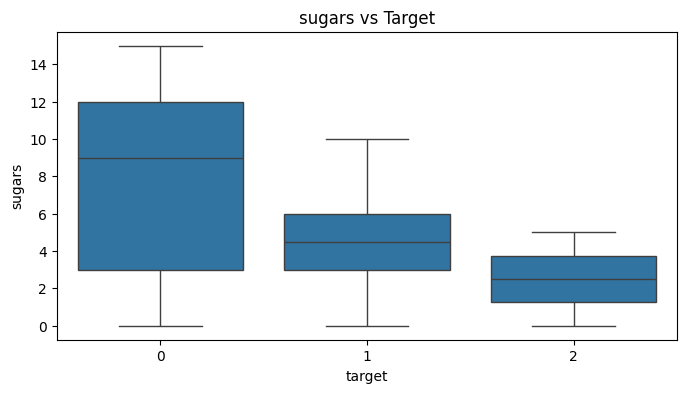

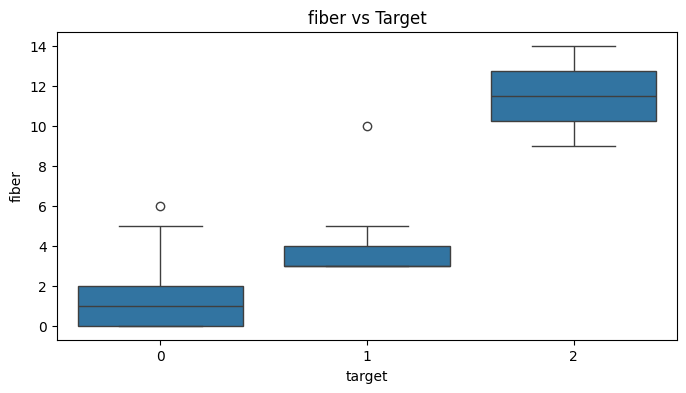

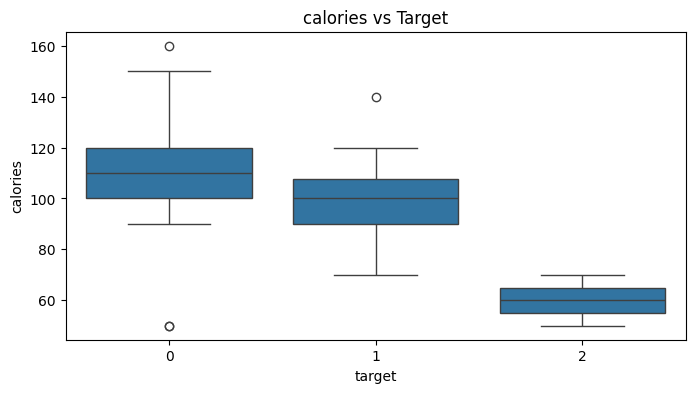

In [51]:
# Visualizing Distributions
for col in ["sugars", "fiber", "calories"]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="target", y=col, data=df)
    plt.title(f"{col} vs Target")
    plt.show()

In [52]:
pd.crosstab(df["mfr"], df["target"], normalize="index")

target,0,1,2
mfr,,,
A,1.000000,0.000000,0.000000
G,0.909091,0.090909,0.000000
K,0.739130,0.173913,0.086957
N,0.166667,0.833333,0.000000
P,0.444444,0.555556,0.000000
Q,1.000000,0.000000,0.000000
R,0.750000,0.250000,0.000000


In [53]:
pd.crosstab(df["shelf"], df["target"], normalize="index")

target,0,1,2
shelf,,,
1,0.700000,0.300000,0.000000
2,0.904762,0.095238,0.000000
3,0.666667,0.277778,0.055556


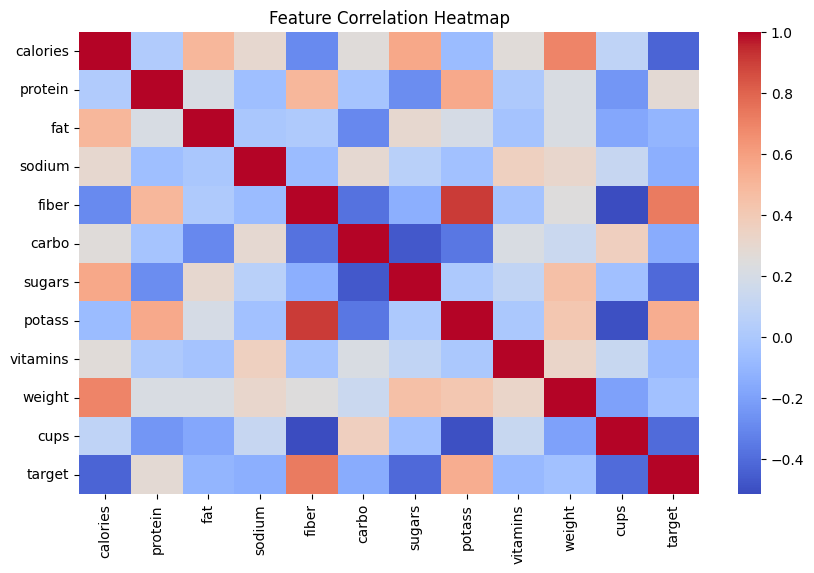

In [54]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols + ["target"]].corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [55]:
DROP_COLS = ["name", "rating"] 
df_model = df.drop(columns=DROP_COLS)
X = df_model.drop(columns=["target"])
y = df_model["target"]

In [56]:
cat_features = ["mfr", "type", "shelf"]
num_features = [c for c in X.columns if c not in cat_features]

print("Categorical:", cat_features)
print("Numerical:", num_features)

Categorical: ['mfr', 'type', 'shelf']
Numerical: ['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins', 'weight', 'cups']


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 61
Testing set size: 16


In [58]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

# Full Model Pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['calories', 'protein', 'fat',
                                                   'sodium', 'fiber', 'carbo',
                                                   'sugars', 'potass',
                                                   'vitamins', 'weight',
                                                   'cups']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mfr', 'type', 'shelf'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [59]:
y_pred = model_pipeline.predict(X_test)
print("--- Classification Report ---\n", classification_report(y_test, y_pred))

--- Classification Report ---
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



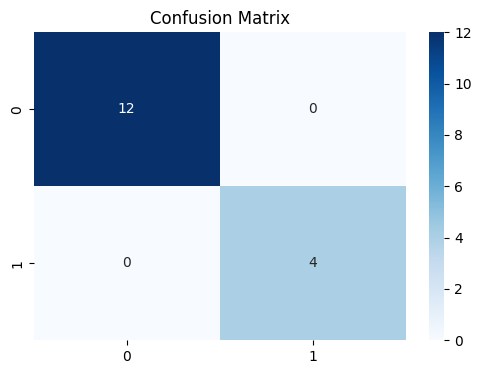

In [60]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [61]:
from sklearn.metrics import balanced_accuracy_score, f1_score

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 Weighted:", f1_score(y_test, y_pred, average="weighted"))

Balanced Accuracy: 1.0
F1 Macro: 1.0
F1 Weighted: 1.0


d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



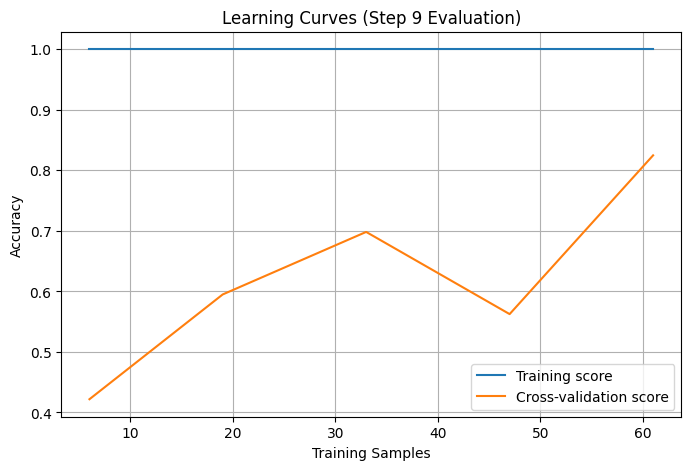

In [62]:
train_sizes, train_scores, test_scores = learning_curve(
    model_pipeline, X, y, cv=5, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curves (Step 9 Evaluation)')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()